In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
from datetime import datetime, timedelta, date, time
from typing import Any, Union
import pandas as pd

In [2]:
def generate_frame(start: datetime, end: datetime, freq: str = '5min'):
	x_axis = pd.date_range(start, end, freq=freq)
	df = pd.DataFrame(index=x_axis)
	df.index.name = 'timestamp'
	return df

def generate_line(slope: float, intercept: float, size: int):
	x_axis = np.linspace(0, size, size)
	y_axis = intercept + slope * x_axis
	return y_axis

def apply_sin(data: np.ndarray, frequency: float, scale: float, size: int, phase: float = 0):
	x_axis = np.linspace(0, size, size)
	y_axis = np.sin(2 * np.pi * (x_axis/frequency) + phase) * scale
	return data + y_axis

def apply_noise(data: np.ndarray, mean: float, scale: float):
	noise = np.random.normal(mean, scale, size=len(data))
	return data + noise

class Line:
	x_axis: np.ndarray
	y_axis: np.ndarray

	def __init__(self, size: int, slope: float = 0, intercept: float = 0):
		self.x_axis = np.linspace(0, size, size)
		self.y_axis = intercept + slope * self.x_axis

	def add_sin(self, frequency: float, scale: float, phase: float = 0):
		sin_wave = np.sin(2 * np.pi * (self.x_axis/frequency) + phase) * scale
		self.y_axis += sin_wave
		return self

	def add_noise(self, mean: float, scale: float):
		noise = np.random.normal(mean, scale, size=len(self.x_axis))
		self.y_axis += noise
		return self

	def add_logistic(self, scale: float, midpoint: float = 0, growth_rate: float = 1):
		sigmoid = scale / ( 1 + np.exp(-growth_rate * (self.x_axis - midpoint)))
		self.y_axis += sigmoid
		return self
	
	def slice(self, start: Union[int, None] = None, end: Union[int, None] = None):
		if start is None:
			self.y_axis[self.x_axis >= end] = 0
		elif end is None:
			self.y_axis[self.x_axis <= start] = 0
		else:
			self.y_axis[( self.x_axis <= start ) | ( self.x_axis >= end )] = 0
		return self

	def __add__(self, line: 'Line'):
		self.y_axis += line.y_axis
		return self

	def __mul__(self, line: 'Line'):
		self.y_axis *= line.y_axis
		return self

	def __truediv__(self, line: 'Line'):
		self.y_axis /= line.y_axis
		return self

	def __rtruediv__(self, line: 'Line'):
		return line.y_axis / self.y_axis


def default_temperature(size: int):
	return Line(size, 0, 70).add_sin(1, 5, -np.pi/2).add_noise(0, 0.25).y_axis

def default_humidity(size: int):
	return Line(size, 0, 40).add_noise(0, 1.5).y_axis

def default_soil_moisture(size: int):
	return Line(size, -0.02, 80).add_noise(0, 0.5).y_axis

def default_light(size: int):
	return Line(size, 0, 30_000).add_sin(1, 30_000, -np.pi/2).add_noise(0, 1500).y_axis.astype(int)

# Too Cold

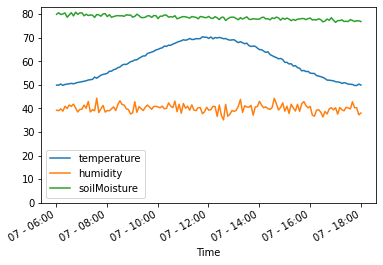

In [4]:
start = datetime.today()
start = start.replace(hour=6, minute=0)
end = start.replace(hour=18, minute=0)
df = generate_frame(start, end)

df['temperature'] = Line(len(df), 0, 60).add_sin(1, 10, -np.pi/2).add_noise(0, 0.25).y_axis
df['humidity'] = default_humidity(len(df))
df['soilMoisture'] = default_soil_moisture(len(df))
df['light'] = default_light(len(df))

ax = df.plot()
date_formatter = matplotlib.dates.DateFormatter('%d - %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time')
df.to_csv('too_cold.csv',)

# Too Dry

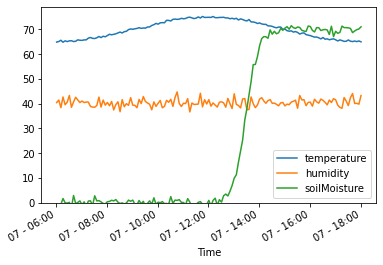

In [17]:
start = datetime.today()
start = start.replace(hour=6, minute=0)
end = start.replace(hour=18, minute=0)
df = generate_frame(start, end)

df['temperature'] = default_temperature(len(df))
df['humidity'] = default_humidity(len(df))
df['soilMoisture'] = Line(len(df), 0, 0).add_logistic(70, 90, 0.35).add_noise(0, 1).y_axis
df['light'] = default_light(len(df))

ax = df.plot()
date_formatter = matplotlib.dates.DateFormatter('%d - %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time')
df.to_csv('too_dry.csv',)

# Too Light

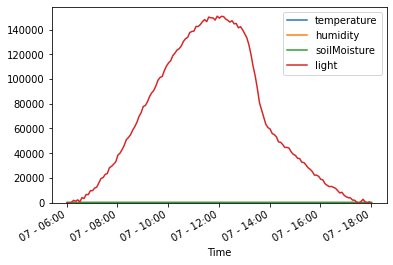

In [23]:
start = datetime.today()
start = start.replace(hour=6, minute=0)
end = start.replace(hour=18, minute=0)
df = generate_frame(start, end)

df['temperature'] = default_temperature(len(df))
df['humidity'] = default_humidity(len(df))
df['soilMoisture'] = default_soil_moisture(len(df))
df['light'] = (Line(len(df), 0, 75_000).add_sin(len(df), 75_000, -np.pi/2) * Line(len(df), 0, 0.5).add_logistic(0.5, 90, -0.5)).add_noise(0, 1000).y_axis

ax = df.plot()
date_formatter = matplotlib.dates.DateFormatter('%d - %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
ax.set_ylim(ymin=0)
ax.set_xlabel('Time')
df.to_csv('too_light.csv',)